<a href="https://colab.research.google.com/github/Lindronics/honours_project/blob/master/notebooks/classification/animals/Animal_classifier_3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Animal classifier

## Setup and imports



In [0]:
%tensorflow_version 2.x

TensorFlow 2.x selected.


In [0]:
!rm -rf /content/*
!wget --no-check-certificate -O dataset.zip "https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228202&authkey=ADau7jkkCZLnQ8k"
!unzip -q dataset.zip

--2020-02-24 12:02:20--  https://onedrive.live.com/download?cid=5691066189D062AB&resid=5691066189D062AB%21228202&authkey=ADau7jkkCZLnQ8k
Resolving onedrive.live.com (onedrive.live.com)... 13.107.42.13
Connecting to onedrive.live.com (onedrive.live.com)|13.107.42.13|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://kusdwq.am.files.1drv.com/y4mVBtH2sbIA9F7sP82lhCkht3UByUY1BrIJJM6UNhJJdL7gLTPjrMZLAUwaKYL-12VqWu9Kfkq5fQLGGecdU73nATpcDnVieQ5_9TRFzGYIp_Ap2101iN3n7_iCIz-T5JbqjSGBIb4atduoaJLUDmA73gCANYmTowHCQFD9p0js5S9iHBo_xNuPqfR5fJKmgJ3cMV7v4CK45VM9doKfIipNg/images_160x120_downsampled.zip?download&psid=1 [following]
--2020-02-24 12:02:22--  https://kusdwq.am.files.1drv.com/y4mVBtH2sbIA9F7sP82lhCkht3UByUY1BrIJJM6UNhJJdL7gLTPjrMZLAUwaKYL-12VqWu9Kfkq5fQLGGecdU73nATpcDnVieQ5_9TRFzGYIp_Ap2101iN3n7_iCIz-T5JbqjSGBIb4atduoaJLUDmA73gCANYmTowHCQFD9p0js5S9iHBo_xNuPqfR5fJKmgJ3cMV7v4CK45VM9doKfIipNg/images_160x120_downsampled.zip?download&psid=1
Resolving kusdwq.am.fi

In [0]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import tensorflow as tf
import tensorflow.keras as K
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns; sns.set()
import os
from os import listdir
from os.path import isdir, join
import shutil
from tqdm import tqdm
from datetime import datetime

from itertools import count
from collections import defaultdict

## Pre-process dataset

In [0]:
whitelist = [
    "pony",
    "alpaca",
    "chicken",
    "peacock",
    # "rabbit",
    "cat",
    # "pretty-chicken",
]

configurations = {
    "train": lambda fname: fname.split("_")[1] == "single" and fname.split("_")[0] in whitelist,
    "test": lambda fname: fname.split("_")[1] != "single" and fname.split("_")[0] in whitelist,
    "train_augmented": lambda fname: fname.split("_")[0] != "human",
    "test_augmented": lambda fname: fname.split("_")[1] != "human",
}


def generate_metadata(config, root="images", channel_prefix=True):
    """ Generates labels to be read by model data loader """

    classes = [c for c in listdir(root) if isdir(join(root, c))]
    samples = {c: 0 for c in classes}
    
    with open(f"labels_{config}.txt", "w") as f:
        for c in classes:
            batches = [b for b in listdir(join(root, c)) if isdir(join(root, c, b)) and configurations[config](b)]
            
            for b in batches:
                lwir_images = [i for i in listdir(join(root, c, b, "lwir")) if i.endswith(".png")]
                rgb_images = ["rgb_" + i[4:] for i in lwir_images] if channel_prefix else [i for i in lwir_images]

                lwir_paths = [join(root, c, b, "lwir", i) for i in lwir_images]
                rgb_paths = [join(root, c, b, "rgb", i) for i in rgb_images]

                for lwir_path, rgb_path in zip(lwir_paths, rgb_paths):
                    f.write(" ".join([rgb_path, lwir_path, c]) + "\n")
                    samples[c] += 1

    print("Dataset composition:")
    sum_ = 0
    for c, s in samples.items():
        sum_ += s
        print(f" - {c}: \t{s}")
    print(f"{sum_} items total.")


In [0]:
def save(path, name, rgb, lwir, label, extension=""):
    rgb_path = os.path.join(path, "rgb", name + f"_{extension}.png")
    lwir_path = os.path.join(path, "lwir", name + f"_{extension}.png")

    cv2.imwrite(rgb_path, rgb)
    cv2.imwrite(lwir_path, lwir)
    return " ".join([rgb_path, lwir_path, label])


def augment_dataset(metadata, augmented_dir, multiplier=2):

    if os.path.exists(augmented_dir):
        shutil.rmtree(augmented_dir)

    datagen = ImageDataGenerator(
        horizontal_flip=True,
        rotation_range=30,
        zoom_range=[0.5, 1],
    )

    classes = dict()
    samples = list()

    # Load labels
    with open(metadata, "r") as f:
        for line in f:
            line = line.split()
            samples.append(line)

            classes[line[-1]] = classes.get(line[-1], 0) + 1

    # Get maximum class samples
    max_class = max(classes.items(), key=lambda x: x[1])
    class_multipliers = {x: max_class[1] * multiplier // y for x, y in classes.items()}
    class_remainders = {x: (max_class[1] * multiplier) % y for x, y in classes.items()}

    # Generate output directory structure
    for label in classes:
        os.makedirs(os.path.join(augmented_dir, label, f"{label}_single_1", "lwir"))
        os.makedirs(os.path.join(augmented_dir, label, f"{label}_single_1", "rgb"))

    # Augment and copy
    augmented_samples = []
    for rgb_path, lwir_path, label in tqdm(samples, position=0):
        rgb = cv2.imread(rgb_path)
        lwir = cv2.imread(lwir_path)

        name = (rgb_path.split("/")[-1]).split(".")[0][4:]
        out_path = os.path.join(augmented_dir, label, f"{label}_single_1")

        # Copy original
        augmented_samples.append(save(out_path, name, rgb, lwir, label, extension=""))

        # Flipped
        rgb_t = datagen.apply_transform(rgb, {"flip_horizontal": True})
        lwir_t = datagen.apply_transform(lwir, {"flip_horizontal": True})

        augmented_samples.append(save(out_path, name, rgb_t, lwir_t, label, extension=0))

        # Random transformations
        remainder = 1 if class_remainders[label] > 0 else 0
        class_remainders[label] -= 1
        for i in range(2, class_multipliers[label] + remainder):
            trans = datagen.get_random_transform(rgb.shape)
            rgb_t = datagen.apply_transform(rgb, trans)
            lwir_t = datagen.apply_transform(lwir, trans)

            augmented_samples.append(save(out_path, name, rgb_t, lwir_t, label, extension=i))


    with open("augmented.txt", "w") as f:
        for line in augmented_samples:
            f.write(line + "\n")

In [0]:
generate_metadata("train", root="images_160x120_downsampled")
generate_metadata("test", root="images_160x120_downsampled")

Dataset composition:
 - pony: 	96
 - ugly-duck: 	0
 - alpaca: 	45
 - chicken: 	86
 - peacock: 	91
 - evil-chicken: 	0
 - rabbit: 	0
 - pig: 	0
 - ferret: 	0
 - human: 	0
 - cat: 	149
 - goose: 	0
 - pretty-chicken: 	0
 - sheep: 	0
467 items total.
Dataset composition:
 - pony: 	16
 - ugly-duck: 	0
 - alpaca: 	40
 - chicken: 	52
 - peacock: 	66
 - evil-chicken: 	0
 - rabbit: 	0
 - pig: 	0
 - ferret: 	0
 - human: 	0
 - cat: 	56
 - goose: 	0
 - pretty-chicken: 	0
 - sheep: 	0
230 items total.


In [0]:
augment_dataset("labels_train.txt", "train_images", multiplier=6)
print("\nTraining dataset")
generate_metadata("train_augmented", root="train_images", channel_prefix=False)

100%|██████████| 467/467 [00:38<00:00, 11.99it/s]



Training dataset
Dataset composition:
 - pony: 	894
 - alpaca: 	894
 - chicken: 	894
 - peacock: 	894
 - cat: 	894
4470 items total.


In [0]:
augment_dataset("labels_test.txt", "test_images", multiplier=2)
print("\nTesting dataset")
generate_metadata("test_augmented", root="test_images", channel_prefix=False)

100%|██████████| 230/230 [00:03<00:00, 69.26it/s] 


Testing dataset
Dataset composition:
 - pony: 	132
 - alpaca: 	132
 - chicken: 	132
 - peacock: 	132
 - cat: 	132
660 items total.


## Dataset

In [0]:
transformation = np.array([
    [1.202290, -0.026808, -50.528589],
    [0.017762, 1.203090, -73.950204],
])

class Dataset(K.utils.Sequence):

    def __init__(self, metadata, rgb_only=False, res=(480, 640), register=True, batch_size=16, split=False, train=True):

        self.rgb_only = rgb_only
        self.res = res
        self.register = register
        self.batch_size = batch_size

        self.classes = defaultdict(count().__next__)
        self.samples = []

        samples = []
        labels = []
        with open(metadata, "r") as f:
            for line in f:
                line = line.split()
                class_label = self.classes[line[-1]]
                samples.append(tuple(line[:2] + [class_label]))
                labels.append(class_label)

        if split:
            train_data, test_data = train_test_split(samples, stratify=labels, test_size=0.2, random_state=42)
            self.samples = train_data if train else test_data
        else:
            self.samples = samples

        self.class_dict = {key: val for val, key in self.classes.items()}
        self.class_labels = [val for key, val in sorted(self.class_dict.items())]

    def __len__(self):
        return len(self.samples) // self.batch_size
    

    def __iter__(self):
        return self


    def load(self, path, register=False):
        img = cv2.imread(path) / 255
        if register:
            img = cv2.resize(img, (480, 640))
            img = cv2.warpAffine(img, transformation, (480, 640))
        img = cv2.resize(img, self.res)
        return img


    def __getitem__(self, idx):
        if idx < self.__len__():
            X = []
            y = []
            for i in range(self.batch_size):
                rgb_path, lwir_path, label = self.samples[idx * self.batch_size + i]

                one_hot = np.zeros(self.num_classes())
                one_hot[label] = 1
                y.append(one_hot)

                rgb = self.load(rgb_path, register=self.register)

                if self.rgb_only:
                    X.append(rgb)
                else:
                    lwir = self.load(lwir_path, register=False)
                    lwir = np.mean(lwir, -1)[..., None]
                    stacked = np.dstack([rgb, lwir])
                    X.append(stacked)

            return np.array(X), np.array(y), [None]
        else:
            raise StopIteration

    def get_labels(self):
        return np.array([sample[-1] for sample in self.samples])

    def num_classes(self):
        return len(self.classes)

    def shape(self):
        return self.res[::-1] + tuple([(3 if self.rgb_only else 4)])


train_data = Dataset(f"labels_train_augmented.txt", rgb_only=False, split=False, res=(120, 160))
test_data = Dataset(f"labels_test_augmented.txt", rgb_only=False, split=False, res=(120, 160))

# train_data = Dataset(f"labels_train_augmented.txt", rgb_only=False, split=False, res=(120, 160))
# test_data = Dataset(f"labels_train_augmented.txt", rgb_only=False, split=False, res=(120, 160))

In [0]:
X, y, _ = train_data[0]
print(X.shape)

X, y, _ = test_data[0]
print(X.shape)
# fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 10))
# ax1.imshow(X[i, ..., 0], cmap="gray")
# ax2.imshow(y_train[i, ..., 0], cmap="gray")

(16, 160, 120, 4)
(16, 160, 120, 4)


## Keras model

## StuffNet

In [0]:
def classifier(x, rgb_only=False):

    ##### Split VIS and LWIR data
    
    rgb = x[..., 0:3]
    lwir = x[..., 3, None]

    ##### VIS Path

    rgb = K.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(rgb)
    rgb = K.layers.Conv2D(filters=16, kernel_size=11, strides=2, padding="valid")(rgb)
    rgb = K.layers.LeakyReLU()(rgb)
    rgb = K.layers.MaxPool2D(pool_size=11, strides=2)(rgb)
    rgb = K.layers.Dropout(0.4)(rgb)

    rgb = K.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(rgb)
    rgb = K.layers.Conv2D(filters=32, kernel_size=7, strides=2, padding="valid")(rgb)
    rgb = K.layers.LeakyReLU()(rgb)
    rgb = K.layers.MaxPool2D(pool_size=5, strides=2)(rgb)
    rgb = K.layers.Dropout(0.4)(rgb)

    rgb = K.layers.Flatten()(rgb)
    rgb = K.layers.Dense(64, activation="relu")(rgb)
    rgb = K.layers.Dropout(0.4)(rgb)
    
    if rgb_only:
        rgb = K.layers.Dense(train_data.num_classes(), activation="softmax")(rgb)
        return rgb

    ##### LWIR Path

    lwir = K.layers.Conv2D(filters=16, kernel_size=3, strides=1, padding="same")(lwir)
    lwir = K.layers.Conv2D(filters=16, kernel_size=11, strides=2, padding="valid")(lwir)
    lwir = K.layers.LeakyReLU()(lwir)
    lwir = K.layers.MaxPool2D(pool_size=11, strides=2)(lwir)
    lwir = K.layers.Dropout(0.4)(lwir)

    lwir = K.layers.Conv2D(filters=32, kernel_size=3, strides=1, padding="same")(lwir)
    lwir = K.layers.Conv2D(filters=32, kernel_size=7, strides=2, padding="valid")(lwir)
    lwir = K.layers.LeakyReLU()(lwir)
    lwir = K.layers.MaxPool2D(pool_size=5, strides=2)(lwir)
    lwir = K.layers.Dropout(0.4)(lwir)

    lwir = K.layers.Flatten()(lwir)
    lwir = K.layers.Dense(64, activation="relu")(lwir)
    lwir = K.layers.Dropout(0.4)(lwir)

    ##### Joint output

    x = K.layers.Concatenate()([rgb, lwir])
    tf.print(x.shape)
    x = K.layers.Dense(train_data.num_classes(), activation="softmax")(x)
    return x



input_tensor = K.layers.Input(train_data.shape())
output_tensor = classifier(input_tensor)

model = K.Model(input_tensor, output_tensor)
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])
model.summary()
weights = model.get_weights()

TensorShape([None, 128])
Model: "model_16"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_19 (InputLayer)           [(None, 160, 120, 4) 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_34 (T [(None, 160, 120, 3) 0           input_19[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_35 (T [(None, 160, 120, 1) 0           input_19[0][0]                   
__________________________________________________________________________________________________
conv2d_90 (Conv2D)              (None, 160, 120, 16) 448         tf_op_layer_strided_slice_34[0][0
__________________________________________________________________

## AlexNet

In [0]:
def classifier(x, rgb_only=False):

    ##### Split VIS and LWIR data
    
    rgb = x[..., 0:3]
    lwir = x[..., 3, None]

    ##### VIS Path

    rgb = K.layers.Conv2D(filters=96, kernel_size=11, strides=2, padding="same", activation="relu")(rgb)
    rgb = K.layers.MaxPool2D(pool_size=3, strides=2)(rgb)

    rgb = K.layers.Conv2D(filters=256, kernel_size=5, strides=2, padding="same", activation="relu")(rgb)
    rgb = K.layers.MaxPool2D(pool_size=3, strides=2)(rgb)

    rgb = K.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu")(rgb)
    rgb = K.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu")(rgb)
    rgb = K.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu")(rgb)
    rgb = K.layers.MaxPool2D(pool_size=3, strides=2)(rgb)

    rgb = K.layers.Flatten()(rgb)
    rgb = K.layers.Dense(1024, activation="relu")(rgb)
    rgb = K.layers.Dense(1024, activation="relu")(rgb)
    
    if rgb_only:
        rgb = K.layers.Dense(train_data.num_classes(), activation="softmax")(rgb)
        return rgb

    ##### LWIR Path

    lwir = K.layers.Conv2D(filters=96, kernel_size=11, strides=2, padding="same", activation="relu")(lwir)
    lwir = K.layers.MaxPool2D(pool_size=3, strides=2)(lwir)

    lwir = K.layers.Conv2D(filters=256, kernel_size=5, strides=2, padding="same", activation="relu")(lwir)
    lwir = K.layers.MaxPool2D(pool_size=3, strides=2)(lwir)

    lwir = K.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu")(lwir)
    lwir = K.layers.Conv2D(filters=384, kernel_size=3, strides=1, padding="same", activation="relu")(lwir)
    lwir = K.layers.Conv2D(filters=256, kernel_size=3, strides=1, padding="same", activation="relu")(lwir)
    lwir = K.layers.MaxPool2D(pool_size=3, strides=2)(lwir)

    lwir = K.layers.Flatten()(lwir)
    lwir = K.layers.Dense(1024, activation="relu")(lwir)
    lwir = K.layers.Dense(1024, activation="relu")(lwir)

    ##### Joint output

    x = K.layers.Concatenate()([rgb, lwir])
    tf.print(x.shape)
    x = K.layers.Dense(train_data.num_classes(), activation="softmax")(x)
    return x



input_tensor = K.layers.Input(train_data.shape())
output_tensor = classifier(input_tensor, rgb_only=False)

model = K.Model(input_tensor, output_tensor)
model.compile(optimizer='sgd',
              loss='mean_squared_error',
              metrics=['accuracy'])
model.summary()
weights = model.get_weights()

TensorShape([None, 2048])
Model: "model_14"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_17 (InputLayer)           [(None, 160, 120, 4) 0                                            
__________________________________________________________________________________________________
tf_op_layer_strided_slice_30 (T [(None, 160, 120, 3) 0           input_17[0][0]                   
__________________________________________________________________________________________________
tf_op_layer_strided_slice_31 (T [(None, 160, 120, 1) 0           input_17[0][0]                   
__________________________________________________________________________________________________
conv2d_72 (Conv2D)              (None, 80, 60, 96)   34944       tf_op_layer_strided_slice_30[0][0
_________________________________________________________________

## Train

In [0]:
# %reload_ext tensorboard
# %tensorboard --logdir logs/fit

In [0]:
%%time
log_dir="logs/fit/" + datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=0, write_graph=True, write_images=True)

# model.fit(train_data, epochs=10, callbacks=[tensorboard_callback], validation_data=test_data)

tf.random.set_seed(42)
np.random.seed(42)

model.set_weights(weights)

model.fit(train_data, epochs=30, validation_data=test_data)

Train for 279 steps, validate for 41 steps
Epoch 1/30
279/279 [==============================] - 34s 123ms/step - loss: 0.1625 - accuracy: 0.2366 - val_loss: 0.1568 - val_accuracy: 0.3262
Epoch 2/30
279/279 [==============================] - 33s 119ms/step - loss: 0.1550 - accuracy: 0.2991 - val_loss: 0.1535 - val_accuracy: 0.4482
Epoch 3/30
279/279 [==============================] - 33s 119ms/step - loss: 0.1477 - accuracy: 0.3833 - val_loss: 0.1487 - val_accuracy: 0.4299
Epoch 4/30
279/279 [==============================] - 33s 119ms/step - loss: 0.1334 - accuracy: 0.4570 - val_loss: 0.1284 - val_accuracy: 0.4482
Epoch 5/30
279/279 [==============================] - 33s 119ms/step - loss: 0.1188 - accuracy: 0.5166 - val_loss: 0.1189 - val_accuracy: 0.5259
Epoch 6/30
279/279 [==============================] - 33s 120ms/step - loss: 0.1101 - accuracy: 0.5614 - val_loss: 0.1157 - val_accuracy: 0.5183
Epoch 7/30
279/279 [==============================] - 33s 119ms/step - loss: 0.1008 - a

In [0]:
model.save_weights('weights.h5')

In [0]:
model.load_weights("weights.h5")

In [0]:
y_pred = np.argmax(model.predict(test_data), axis=1)
y_test = test_data.get_labels()[:y_pred.shape[0]]
print(classification_report(y_test, y_pred, target_names=test_data.class_labels))

              precision    recall  f1-score   support

        pony       0.38      0.46      0.42       132
      alpaca       1.00      0.34      0.51       132
     chicken       0.10      0.02      0.03       132
     peacock       0.21      0.49      0.29       132
         cat       0.98      0.88      0.93       128

    accuracy                           0.44       656
   macro avg       0.53      0.44      0.43       656
weighted avg       0.53      0.44      0.43       656



In [0]:
# test_data.get_labels().shape
# np.argmax(y_pred, axis=1).shape

(1124,)

In [0]:
print("Pred:", np.bincount(y_pred))
print("True:", np.bincount(y_test))

Pred: [118  65  94 235 144]
True: [132 132 132 132 128]


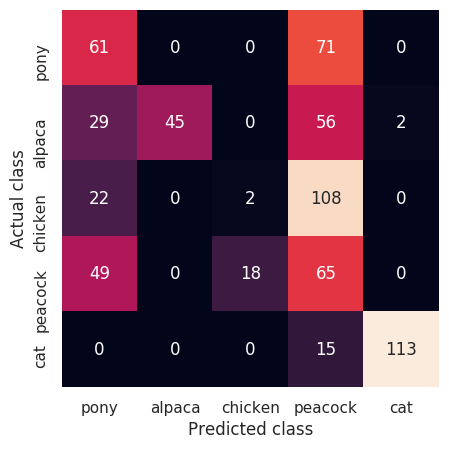

In [0]:
# y_pred = model.predict_classes(X_test)

y_pred_named = [test_data.class_labels[x] for x in y_pred]
y_test_named = [test_data.class_labels[x] for x in y_test]
confusion = confusion_matrix(y_test_named, y_pred_named, labels=test_data.class_labels)

f, ax = plt.subplots(figsize=(5, 5), dpi=100)
ax = sns.heatmap(confusion, annot=True, xticklabels=test_data.class_labels, yticklabels=test_data.class_labels, square=True, cbar=False, fmt="d")
ax.set(xlabel='Predicted class', ylabel='Actual class')
plt.show()

In [0]:
n = 5

ids = np.random.randint(0, len(test_data)-1, size=n)
preds = model.predict(test_data[ids])

fig, axes = plt.subplots(1, n, figsize=(15, 10))

for id_, ax, pred in zip(ids, axes, preds):
    ax.imshow(X_test[id_][..., 1:])
    ax.axis('off')
    ax.set_title(data.class_labels[pred])

plt.tight_layout()

ValueError: ignored

defaultdict(<method-wrapper '__next__' of itertools.count object at 0x7f3ea2c8f6c8>,
            {'alpaca': 2, 'chicken': 4, 'peacock': 3, 'pig': 0, 'pony': 1})